In [22]:
import matplotlib.pyplot as plt
import torch
import pytorch_measure as pm
import numpy as np
N = 17 # number of atoms
M = 1000 # Number of datapoints
amin = -5
amax = 3
verbose = True
dev = 'cpu'


torch.manual_seed(1)

def regression_model(a, x):
    return a+x

x = torch.linspace(0, 10, M).view(-1, 1)
data = regression_model(torch.randn(M).to(dev) - 2, x.view(1, -1)).view(-1, 1)
w = torch.rand(N,dtype=torch.float).to(dev)
w = torch.nn.parameter.Parameter(w/w.sum())
l = torch.linspace(amin, amax, N, requires_grad=False).to(dev)

index = []
for i in range(M):
    ab = (regression_model(l, x[i]) - data[i]).abs()
    index.append(torch.argmin(ab))

def NLLLoss(m:list[pm.Measure]):
    return -(m[0].weights[index]).log().sum()

sd = (l[index] - data)**2
def WardLoss(w):
    return sum(sd * w[index])

def K(d):
        return 1/np.sqrt(2*np.pi)*np.exp(-d**2/2)
h=1.06*M**(-1/5)
# K( (y - yj) / h )
kde_mat = K((data.view(-1,1) - regression_model(l, x)) / h)

#a = torch.sum(kde_mat, dim=0)

def KDENLLLoss(m):
    return -(torch.matmul(kde_mat, m[0].weights.view(-1,1)) / (M*h)).log().sum()


Epoch: 0          Lr was reduced to: 0.700000000
Epoch: 1          Lr was reduced to: 0.490000000
Epoch: 2          Lr was reduced to: 0.343000000
Epoch: 3          Lr was reduced to: 0.240100000
Epoch: 5          Lr was reduced to: 0.168070000
Epoch: 6          Lr was reduced to: 0.117649000
Epoch: 7          Lr was reduced to: 0.082354300
Epoch: 8          Lr was reduced to: 0.057648010
Epoch: 10         Loss: 2496.197753906 LR: 0.057648010
Epoch: 11         Lr was reduced to: 0.040353607
Epoch: 12         Lr was reduced to: 0.028247525
Epoch: 13         Lr was reduced to: 0.019773267
Epoch: 20         Loss: 2330.396240234 LR: 0.019773267
Epoch: 26         Lr was reduced to: 0.013841287
Epoch: 29         Lr was reduced to: 0.009688901
Epoch: 30         Lr was reduced to: 0.006782231
Epoch: 40         Loss: 2217.031982422 LR: 0.006782231
Epoch: 50         Loss: 2192.611083984 LR: 0.006782231
Epoch: 60         Lr was reduced to: 0.004747562
Epoch: 70         Loss: 2163.751953125 LR: 0.

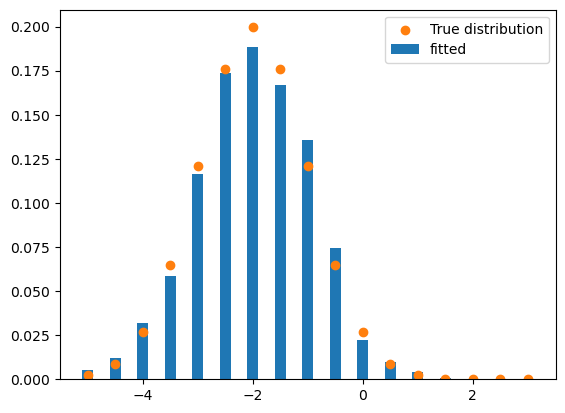

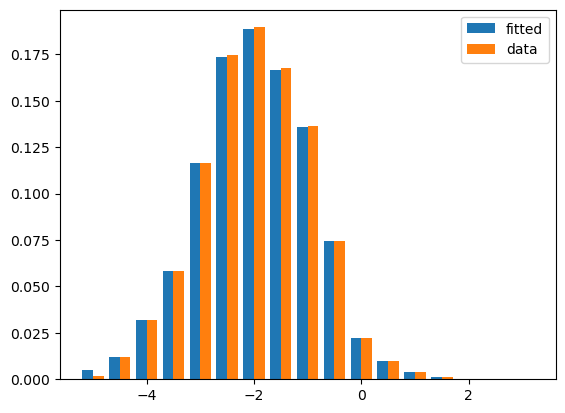

1236213224784::1236213227472


In [23]:
measure = pm.Measure(locations=l, weights=w, device=dev)
opt = pm.Optimizer([measure], lr=1e-1)

opt.minimize(NLLLoss, verbose=True, print_freq=10, max_epochs=1000, tol_const=1e-3, adaptive=True)

mu=0 #Create true values
sigma=1
xs = l.detach()
y=1/(np.sqrt(2*np.pi)*sigma)*torch.exp(-(xs+2-mu)**2/(2*sigma**2))
y/=sum(y) #Normalize


plt.bar(l, opt.measures[0].weights.tolist(), width = 0.2, label='fitted')
#plt.bar(l-0.1, torch.sum(kde_mat, dim=0)/torch.sum(kde_mat), zorder=0, width=0.1)
plt.scatter(xs, y, zorder=2, label="True distribution")
plt.legend()

plt.show()

### sergei visualize ###
locations_grid_size = (amax - amin) / (N - 1)
bins=torch.linspace(amin - locations_grid_size / 2, amax + locations_grid_size / 2, N + 1)
h,b = torch.histogram(data - x, bins=bins)

# side-by-side histogram. Can it be done smarter?
plt.bar(l - 0.1, opt.measures[0].weights.tolist(), width = 0.2, label='fitted')
plt.bar(l + 0.1, h / h.sum(), width = 0.2, label='data')
plt.legend(loc='upper right')
plt.show()

print(str(id(measure)) + "::" + str(id(opt.measures[0])))

#LR         to 1e-4             to 1e-5
#1e-3  -  2147.958496094        2145.816650391
#1e-2  -  2147.958496094        2145.816650391
#1e-1  -  2149.463867188        2145.826660156

In [24]:
measure.weights

Parameter containing:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True)